# SLIC Tutorial

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import skimage.data
from skimage.util import img_as_float, regular_grid
from skimage.color import rgb2lab
from skimage.segmentation import mark_boundaries
from tqdm import tqdm_notebook as tqdm

## Load Image

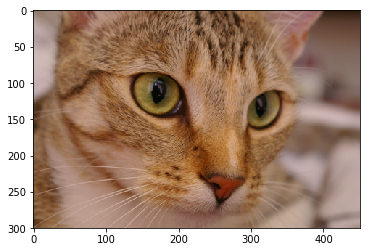

In [2]:
raw_img = skimage.data.chelsea()
plt.imshow(raw_img)

- カラー画像の場合、RGB空間から[Lab空間](https://ja.wikipedia.org/wiki/Lab%E8%89%B2%E7%A9%BA%E9%96%93)に変換する
    - 色空間内での距離を人間の知覚と近くするため

In [3]:
image = img_as_float(raw_img)  # 0〜1のfloatに変換
if image.ndim == 2:  # 1ch
    image = image[..., np.newaxis]
else:  # 3ch
    image = rgb2lab(raw_img)  # Lab空間に変換
    
print(image.shape)

(300, 451, 3)


## SLIC algorithm
- ほぼk-means。各ピクセルをsegmentに割り振っていく。
- 距離の定義がポイント。座標距離と色距離の和。
$$
\begin{align}
d &= d_{spatial} * compactness + d_{color}, \\
{\rm where:} \\
d_{spatial} &= \frac{\sqrt{(x-x_c)^2 + (y-y_c)^2}}{step} \\
d_{color} &= \sqrt{(l-l_c)^2 + (a-a_c)^2 + (b-b_c)^2} \\
step &= \sqrt{\frac{height \times width}{n\_segments}}
\end{align}
$$

### ハイパーパラメータ
- n_segments: 領域数。k-meansのKに相当。
- compactness: 座標距離と色距離のどちらを重視するかを決められる。compactnessが大きいほど座標距離を重視するため、各領域が正方形に近くなる。
- max_iter: 10でOK。

In [4]:
n_segments = 100 
compactness = 10
max_iter = 10

In [5]:
print (image.min())

-24.9717447928


### Initialization
- 更新する変数
    - *segments*: 各segmentの中心座標(y, x)と色情報(L, b, a)が入った配列。shape=(n_segments, 5)
    - *nearest_segments*: 各座標が属するsegment番号。shape=(height, width)
- 初期状態
    - *segments*: 座標は等間隔の格子状に。色は0。
    - *nearest_segments*: 特になし

In [6]:
height, width = image.shape[:2]
step = int(np.sqrt(height * width / n_segments))

coord_y = np.arange(step // 2, height, step)
coord_x = np.arange(step // 2, width, step)
n_segments = len(coord_y) * len(coord_x)  # 再計算

segments_coord = np.array(np.meshgrid(coord_y, coord_x)).reshape(2, n_segments).T  # shape=(n_segments, 2)
segments_color = np.zeros((n_segments, image.shape[2]))
segments = np.concatenate([segments_coord, segments_color], axis=1) 
print(segments.shape)

(104, 5)


In [7]:
nearest_segments = np.empty((height, width), dtype=np.intp)
print(nearest_segments.shape)

(300, 451)


### Main
- STEP 1: *nearest_segments*の更新
    - 各点を、距離が最も近いsegmentに割り振る
    - 1点も更新されなかったらbreak
    
- STEP 2: *segments*の更新
    - 各segmentに属する全ての点の平均座標・色を計算し、*segments*に代入

In [8]:
for i in tqdm(range(max_iter)):
    # STEP 1: "nearest_segments" の更新
    distance = np.ones((height, width)) * 1e08 # 距離格納用。めっちゃデカい初期値
    is_changed = False

    for k in range(n_segments):
        
        # セグメントの中心座標
        cy = segments[k, 0]
        cx = segments[k, 1]

        # 探索範囲
        y_min = int(max(cy - 2 * step, 0))
        y_max = int(min(cy + 2 * step + 1, height))
        x_min = int(max(cx - 2 * step, 0))
        x_max = int(min(cx + 2 * step + 1, width))

        # この中をWRITE ME!
        for y in range(y_min, y_max):
            dy = (cy - y) ** 2
            for x in range(x_min, x_max):
                dist_spatial = (dy + (cx - x) ** 2) / step ** 2
                dist_color = np.sum((image[y, x] - segments[k, 2:]) ** 2)
                dist = dist_spatial * compactness ** 2 + dist_color
                
                if distance[y, x] > dist:
                    nearest_segments[y, x] = k
                    distance[y, x] = dist
                    is_changed = True

    # 1点も更新されなかったらbreak
    if not is_changed:
        break

    # STEP 2: "segments" の更新 (WRITE ME!)
    for k in range(n_segments):
            indices = np.where(nearest_segments == k)
            segments[k, 0] = np.mean(indices[0])
            segments[k, 1] = np.mean(indices[1])
            segments[k, 2:] = np.mean(image[indices], axis=0)


A Jupyter Widget

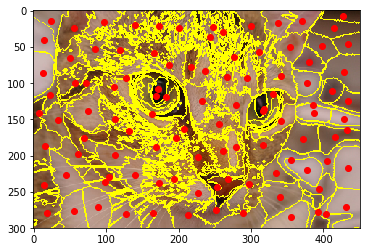

In [9]:
plt.imshow(mark_boundaries(raw_img, nearest_segments))
plt.plot(segments[:, 1], segments[:, 0], 'o', color='r')

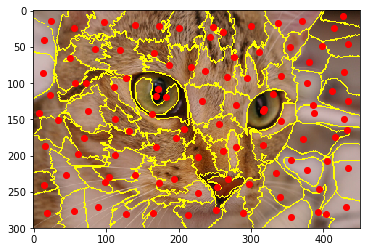

In [10]:
plt.imshow(mark_boundaries(raw_img, skimage.segmentation.slic(raw_img, enforce_connectivity=True)))
plt.plot(segments[:, 1], segments[:, 0], 'o', color='r')